数据分析：
+ 总览
    ID:
    •Survived(存活与否)
    •Pclass（客舱等级，较为重要）
    •Name（姓名，可提取出更多信息）
    •Sex（性别，较为重要）
    •Age（年龄，较为重要）
    •Parch（直系亲友）
    •SibSp（旁系）
    •Ticket（票编号）
    •Fare（票价）
    •Cabin（客舱编号）
    •Embarked（上船的港口编号）
+ 使用统计学与绘图对数据初步分析
主要分析各类乘客存活率情况
（大致分为10类左右）
+ 数据清洗
填充缺失值（构建随机森林模型）
按姓氏等进行划分，之后同组之间进行识别，查看存活率情况
之后按存活率情况进行分组，挑出反常的一组
选取特征，进行特征转换，划分训练集与测试集
+ 建模和优化
网络搜索选最优参数，之后训练模型，最后交叉验证
+ 进行预测


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 总览

In [12]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
df_all = pd.concat([train, test]).reset_index(drop=True)
df_all.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [13]:
#查看
df_all.info()
df_all.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


从数据中可以发现有些属性存在null 

# 绘图分析

Percentage of females who survived: 74.20382165605095
Percentage of males who survived: 18.890814558058924


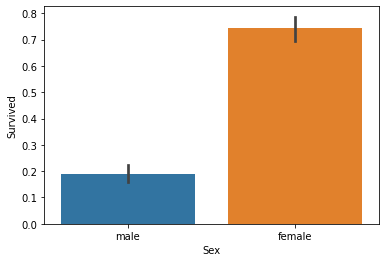

In [14]:
#女性的生存率远大于男性
#draw a bar plot of survival by sex
sns.barplot(x="Sex", y="Survived", data=train)

#print percentages of females vs. males that survive
print("Percentage of females who survived:", train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100)

print("Percentage of males who survived:", train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

Percentage of SibSp = 0 who survived: 34.53947368421053
Percentage of SibSp = 1 who survived: 53.588516746411486
Percentage of SibSp = 2 who survived: 46.42857142857143


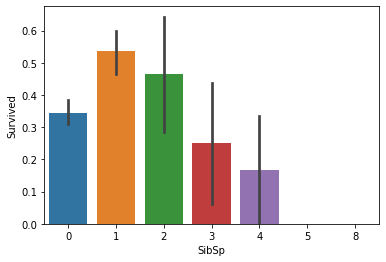

In [15]:
#贵的仓位自然有更高的生存率 
#draw a bar plot for SibSp vs. survival
sns.barplot(x="SibSp", y="Survived", data=train)

#I won't be printing individual percent values for all of these.
print("Percentage of SibSp = 0 who survived:", train["Survived"][train["SibSp"] == 0].value_counts(normalize = True)[1]*100)

print("Percentage of SibSp = 1 who survived:", train["Survived"][train["SibSp"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of SibSp = 2 who survived:", train["Survived"][train["SibSp"] == 2].value_counts(normalize = True)[1]*100)

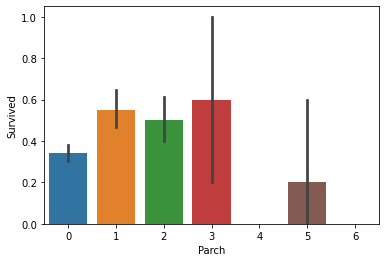

In [18]:
#有一个兄弟姐妹的一般有更高的生存率
#draw a bar plot for Parch vs. survival
sns.barplot(x="Parch", y="Survived", data=train)
plt.show()

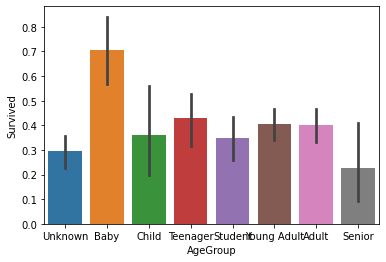

In [19]:
#婴儿的生存率奇高
#sort the ages into logical categories
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels = labels)

#draw a bar plot of Age vs. survival
sns.barplot(x="AgeGroup", y="Survived", data=train)
plt.show()

Percentage of CabinBool = 1 who survived: 66.66666666666666
Percentage of CabinBool = 0 who survived: 29.985443959243085


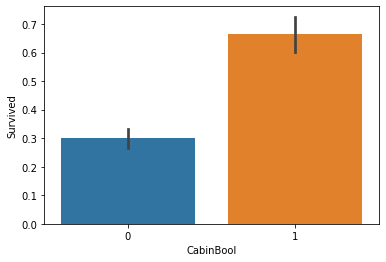

In [20]:
train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

#calculate percentages of CabinBool vs. survived
print("Percentage of CabinBool = 1 who survived:", train["Survived"][train["CabinBool"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of CabinBool = 0 who survived:", train["Survived"][train["CabinBool"] == 0].value_counts(normalize = True)[1]*100)
#draw a bar plot of CabinBool vs. survival
sns.barplot(x="CabinBool", y="Survived", data=train)
plt.show()

# 数据清理

In [52]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
df_all = pd.concat([train, test]).reset_index(drop=True)
#查看缺失值
print(pd.isnull(train).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [53]:
#Cabin
train = train.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

train = train.drop(['Ticket'], axis = 1)
test = test.drop(['Ticket'], axis = 1)

In [54]:
#大多数人都去了南安普敦
print("Number of people embarking in Southampton (S):")
southampton = train[train["Embarked"] == "S"].shape[0]
print(southampton)

print("Number of people embarking in Cherbourg (C):")
cherbourg = train[train["Embarked"] == "C"].shape[0]
print(cherbourg)

print("Number of people embarking in Queenstown (Q):")
queenstown = train[train["Embarked"] == "Q"].shape[0]
print(queenstown)

#填充缺失值
train = train.fillna({"Embarked": "S"})

Number of people embarking in Southampton (S):
644
Number of people embarking in Cherbourg (C):
168
Number of people embarking in Queenstown (Q):
77


In [55]:
combine = [train, test]

#提取Title
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [56]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


In [57]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [58]:
#选择平均值作为缺失项的填充值
train['Age']=train['Age'].fillna(train['Age'].mean())
test['Age']=test['Age'].fillna(test['Age'].mean())

In [59]:
#sex embarked数字化
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,2,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,1,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,1,1


In [60]:
#均值填充 
for x in range(len(test["Fare"])):
    if pd.isnull(test["Fare"][x]):
        pclass = test["Pclass"][x] #Pclass = 3
        test["Fare"][x] = round(train[train["Pclass"] == pclass]["Fare"].mean(), 4)
        
#映射fare值
train['FareBand'] = pd.qcut(train['Fare'], 4, labels = [1, 2, 3, 4])
test['FareBand'] = pd.qcut(test['Fare'], 4, labels = [1, 2, 3, 4])

#丢弃Null
train = train.drop(['Fare'], axis = 1)
test = test.drop(['Fare'], axis = 1)

C:\Users\HP\AppData\Local\Temp/ipykernel_21492/2649941180.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Fare"][x] = round(train[train["Pclass"] == pclass]["Fare"].mean(), 4)


In [61]:
train = train.drop(['Name'], axis = 1)
test = test.drop(['Name'], axis = 1)

In [62]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,FareBand
0,1,0,3,0,22.0,1,0,1,1,1
1,2,1,1,1,38.0,1,0,2,3,4
2,3,1,3,1,26.0,0,0,1,2,2
3,4,1,1,1,35.0,1,0,1,3,4
4,5,0,3,0,35.0,0,0,1,1,2


In [63]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,FareBand
0,892,3,0,34.5,0,0,3,1,1
1,893,3,1,47.0,1,0,1,3,1
2,894,2,0,62.0,0,0,3,1,2
3,895,3,0,27.0,0,0,1,1,2
4,896,3,1,22.0,1,1,1,3,2


# 建模优化

In [68]:
from sklearn.model_selection import train_test_split

predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train["Survived"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.22, random_state = 0)

In [72]:
# GaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)
# Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)
# Linear SVC
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_val)
acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_perceptron)
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

78.68
78.68
70.56
79.7
81.22
77.16
81.73
80.2
73.1


D:\4_code\1_anaconda\envs\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\4_code\1_anaconda\envs\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


83.76


In [73]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier'],
    'Score': [acc_svc, acc_knn, acc_logreg, 
              acc_randomforest, acc_gaussian, acc_perceptron,acc_linear_svc, acc_decisiontree,
              acc_sgd, acc_gbk]})
models.sort_values(by='Score', ascending=False)

,Model,Score
9,Gradient Boosting Classifier,83.76
3,Random Forest,81.73
5,Perceptron,81.22
1,KNN,80.20
6,Linear SVC,79.70
2,Logistic Regression,78.68
4,Naive Bayes,78.68
7,Decision Tree,77.16
8,Stochastic Gradient Descent,73.10
0,Support Vector Machines,70.56


In [79]:
#调参
from sklearn.model_selection import GridSearchCV 
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=300,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(x_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 60}, 0.8565675997862456)

# 预测

In [82]:
#用调参好的模型进行预测 并将结果放入submission.csv中
ids = test['PassengerId']
gbk = GradientBoostingClassifier(n_estimators= 60)
gbk.fit(x_train, y_train)
predictions = gbk.predict(test.drop('PassengerId', axis=1))

#set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('submission.csv', index=False)